# CLUSTERING 



In [94]:
import pandas as pd


# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Categorizar por partes del día
def time_to_period(hour):
    if 6 <= hour < 12:
        return 0 #Día
    elif 12 <= hour < 18:
        return 1 #Tarde
    else:
        return 2 #Noche

df['PeriodoDia'] = df['Time'].apply(lambda t: time_to_period(t.hour) if pd.notnull(t) else None)

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)


# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df = df.dropna()

# Mostrar información y primeros registros
print("Tipos de datos:")
print(df.dtypes)
print("\nPrimeros registros:")
print(df.head())



Tipos de datos:
Date             datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)               Int64
NMHC(GT)                  Int64
C6H6(GT)                float64
PT08.S2(NMHC)             Int64
NOx(GT)                   Int64
PT08.S3(NOx)              Int64
NO2(GT)                   Int64
PT08.S4(NO2)              Int64
PT08.S5(O3)               Int64
T                       float64
RH                      float64
AH                      float64
Dia                       Int64
Mes                       Int64
Anio                      Int64
DiaSemana                 Int64
PeriodoDia                Int64
dtype: object

Primeros registros:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            939      131   
3 2004-03-10     

# IMPUTAR VALORES -200 A NAN Y PONER A LOS DEMAS MEDIA O MEDIANA

In [95]:
import pandas as pd
import numpy as np

# Columnas a imputar (excepto 'NMHC(GT)')
imputar_nan = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 
               'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Eliminar la columna 'NMHC(GT)'
df = df.drop(columns=['NMHC(GT)'], errors='ignore')

# Convertir columnas a tipo float para evitar problemas de tipo de dato
df[imputar_nan] = df[imputar_nan].astype(float)

# Reemplazar valores -200 con NaN en las columnas seleccionadas
df[imputar_nan] = df[imputar_nan].replace(-200, np.nan)

# Imputación con la media (redondeando a 2 decimales)
df_mean_imputed = df.copy()
df_mean_imputed[imputar_nan] = df_mean_imputed[imputar_nan].fillna(df_mean_imputed[imputar_nan].mean()).round(2)

# Imputación con la mediana (redondeando a 2 decimales)
df_median_imputed = df.copy()
df_median_imputed[imputar_nan] = df_median_imputed[imputar_nan].fillna(df_median_imputed[imputar_nan].median()).round(2)

# Comparar los resultados
print("Con imputación de la media:")
print(df_mean_imputed[imputar_nan].head())

print("\nCon imputación de la mediana:")
print(df_median_imputed[imputar_nan].head())

# Verificar tipos de datos después de la conversión
print(df.dtypes)


Con imputación de la media:
   CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)  PT08.S1(CO)  PT08.S2(NMHC)  \
0       3        12      166      113         1360           1046   
1       2         9      103       92         1292            955   
2       2         9      131      114         1402            939   
3       2         9      172      122         1376            948   
4       2         6      131      116         1272            836   

   PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  T  RH  AH  
0          1056          1692         1268 14  49   1  
1          1174          1559          972 13  48   1  
2          1140          1555         1074 12  54   1  
3          1092          1584         1203 11  60   1  
4          1205          1490         1110 11  60   1  

Con imputación de la mediana:
   CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)  PT08.S1(CO)  PT08.S2(NMHC)  \
0       3        12      166      113         1360           1046   
1       2         9      103       92         1292  

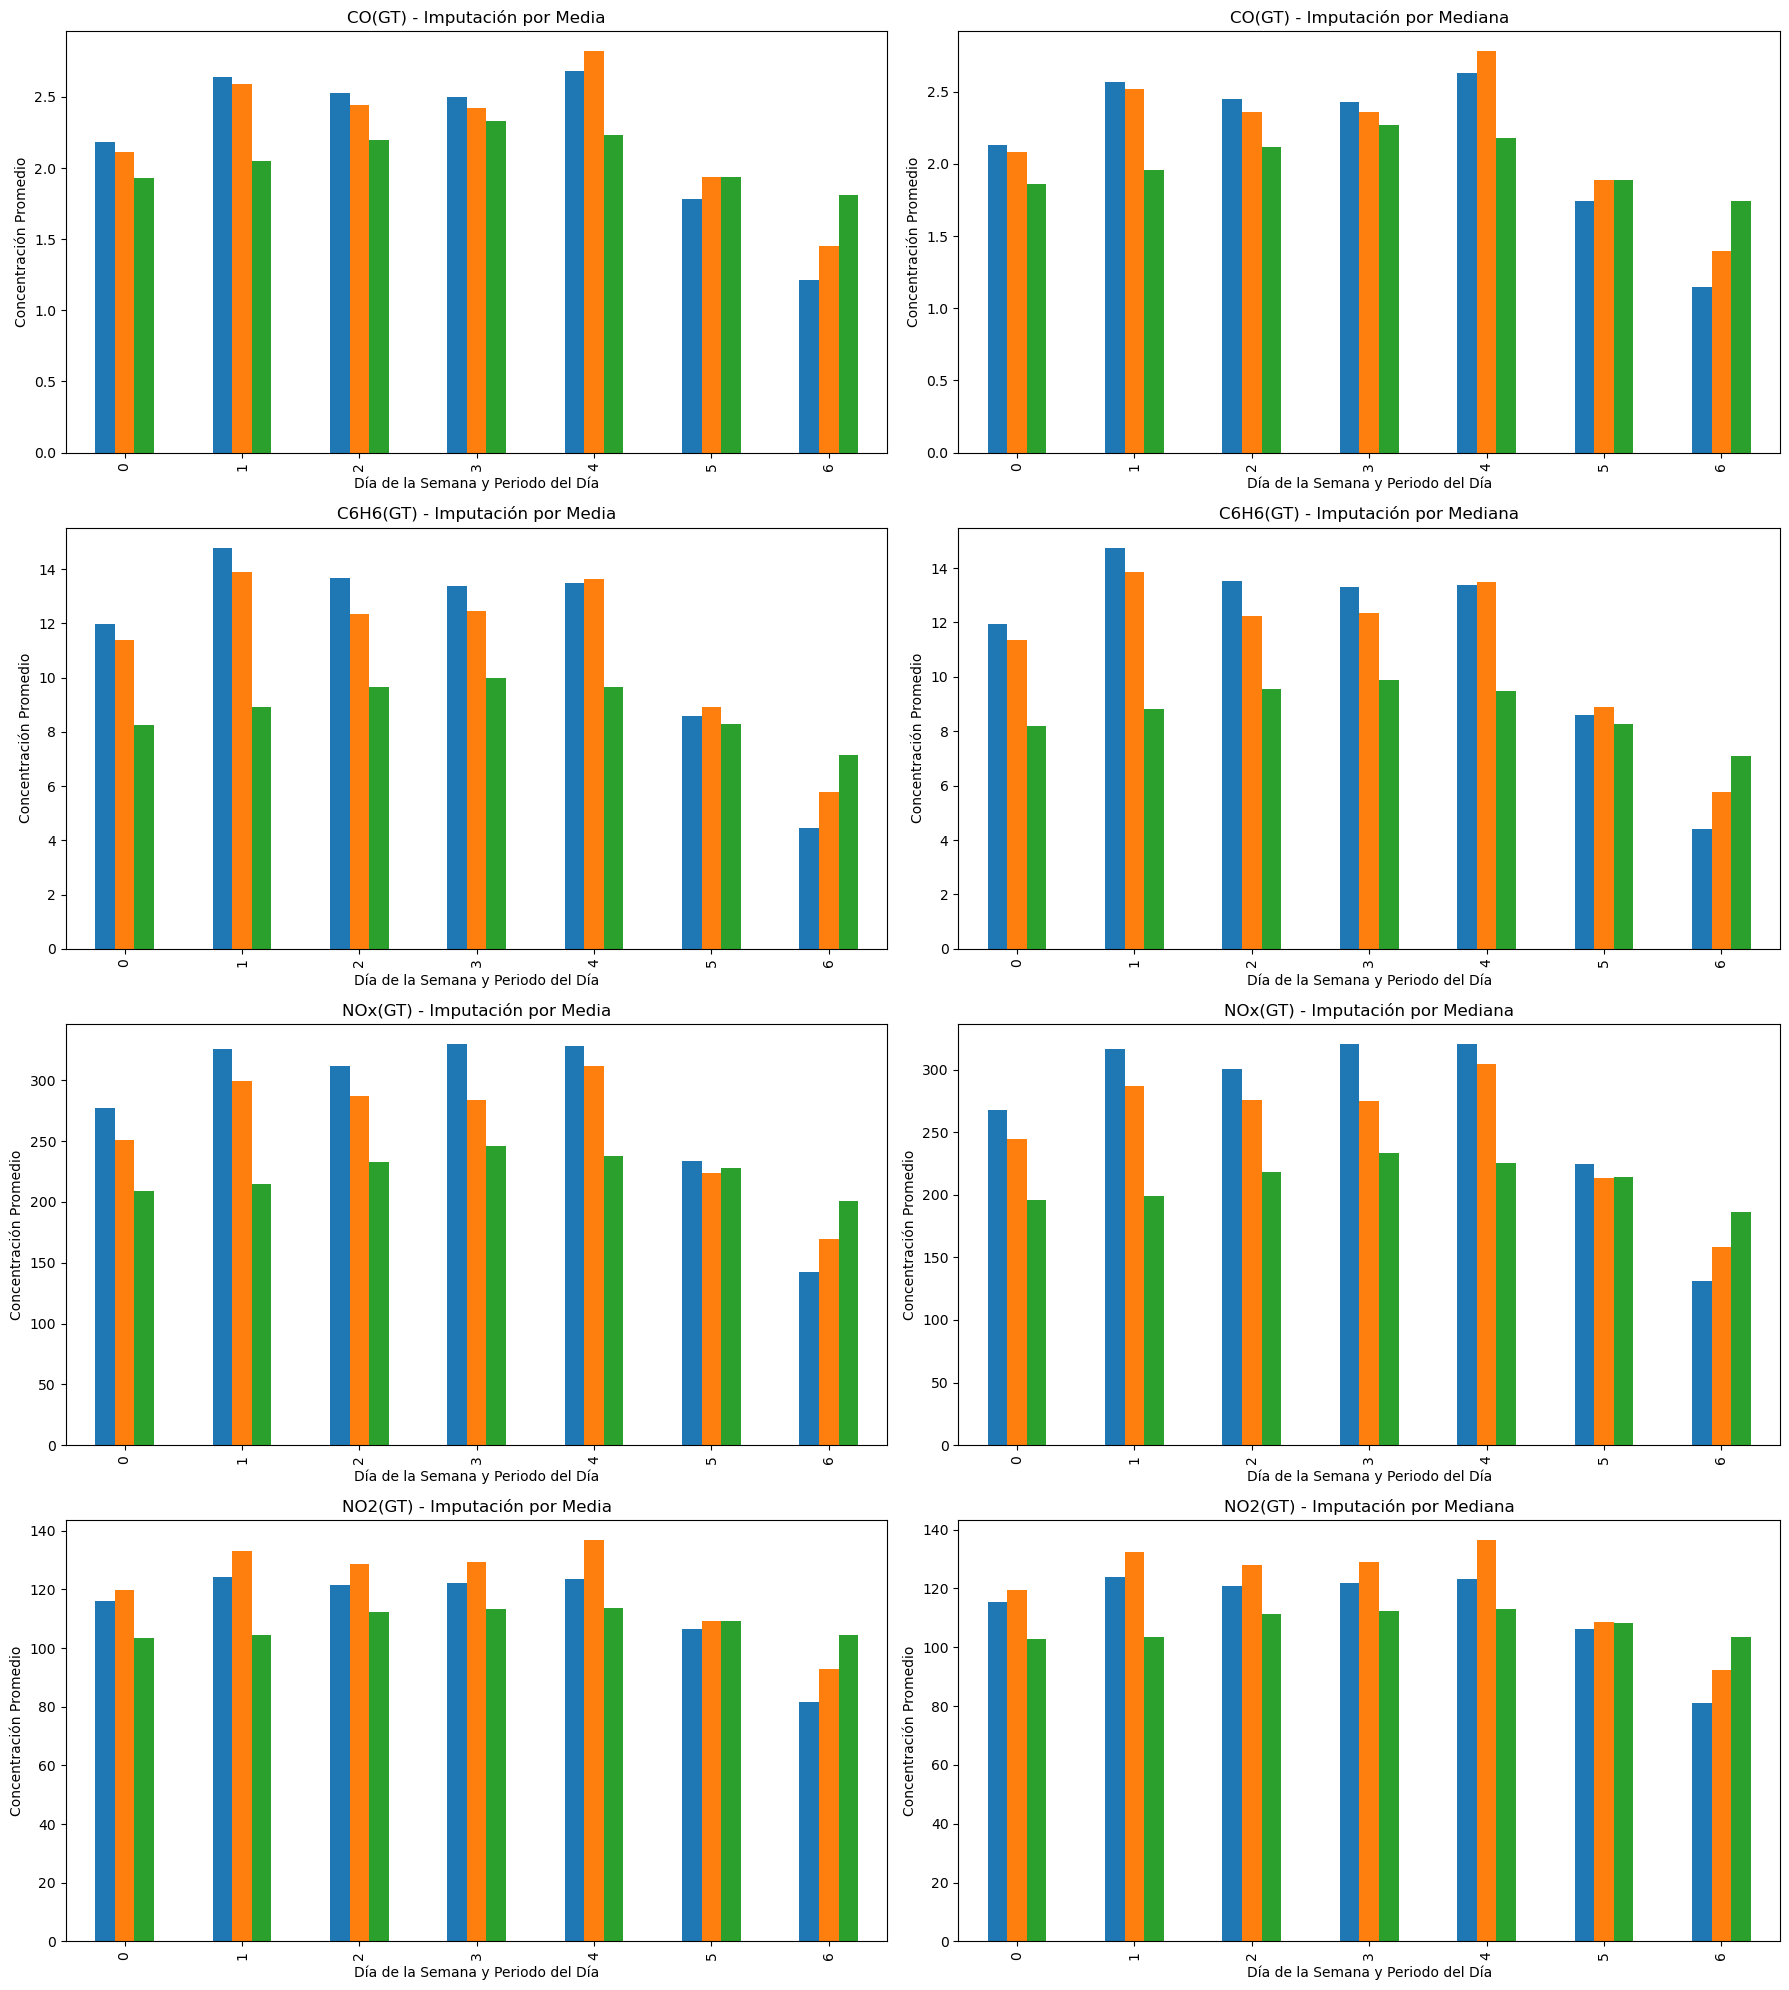

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Seleccionar las columnas de interés
gases_media_semana = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PeriodoDia', 'DiaSemana']
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Agrupar por día de la semana y periodo del día, y calcular la media de cada gas para cada método
df_grouped_mean = df_mean_imputed[gases_media_semana].groupby(['DiaSemana', 'PeriodoDia']).mean().reset_index().round(2)
df_grouped_median = df_median_imputed[gases_media_semana].groupby(['DiaSemana', 'PeriodoDia']).mean().reset_index().round(2)

# Crear una figura con subgráficos de 2 columnas (una para cada método)
fig, axes = plt.subplots(len(gases), 2, figsize=(18, 20))

# Generar los gráficos comparativos
for i, gas in enumerate(gases):
    # Datos imputados con la media
    gas_data_mean = df_grouped_mean[['DiaSemana', 'PeriodoDia', gas]].set_index(['DiaSemana', 'PeriodoDia']).unstack()
    gas_data_mean.plot(kind='bar', ax=axes[i, 0], legend=False)
    axes[i, 0].set_title(f'{gas} - Imputación por Media')
    axes[i, 0].set_xlabel('Día de la Semana y Periodo del Día')
    axes[i, 0].set_ylabel('Concentración Promedio')

    # Datos imputados con la mediana
    gas_data_median = df_grouped_median[['DiaSemana', 'PeriodoDia', gas]].set_index(['DiaSemana', 'PeriodoDia']).unstack()
    gas_data_median.plot(kind='bar', ax=axes[i, 1], legend=False)
    axes[i, 1].set_title(f'{gas} - Imputación por Mediana')
    axes[i, 1].set_xlabel('Día de la Semana y Periodo del Día')
    axes[i, 1].set_ylabel('Concentración Promedio')

# Ajustar la distribución de los gráficos
plt.tight_layout()
plt.show()


# outliders 

In [91]:
import pandas as pd
import numpy as np

# Columnas a analizar
columns_to_check = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 
                    'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Detectar outliers usando IQR
for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f'{col} tiene {outliers.shape[0]} valores atípicos.')


CO(GT) tiene 215 valores atípicos.
C6H6(GT) tiene 228 valores atípicos.
NOx(GT) tiene 435 valores atípicos.
NO2(GT) tiene 107 valores atípicos.
PT08.S1(CO) tiene 118 valores atípicos.
PT08.S2(NMHC) tiene 65 valores atípicos.
PT08.S3(NOx) tiene 241 valores atípicos.
PT08.S4(NO2) tiene 97 valores atípicos.
PT08.S5(O3) tiene 93 valores atípicos.
T tiene 3 valores atípicos.
RH tiene 0 valores atípicos.
AH tiene 2 valores atípicos.


# COMO HAY OUTLIDERS VAMOS A USAR LA MEDIANA 
Si se requiere una mayor estabilidad y resistencia al ruido, es mejor la mediana.

# DATOS NORMALOIZADOS Y SACAR INDICE DE CONTAMINACIÓN 

In [100]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas relevantes de gases contaminantes
gases_contaminantes = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
otras_columnas = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Combinar todas las columnas que se van a normalizar
columnas_a_normalizar = gases_contaminantes + otras_columnas

# Convertir las columnas a tipo numérico, manejando errores
df_median_imputed[columnas_a_normalizar] = df_median_imputed[columnas_a_normalizar].apply(pd.to_numeric, errors='coerce')


# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Normalizar las columnas seleccionadas
df_median_imputed[columnas_a_normalizar] = scaler.fit_transform(df_median_imputed[columnas_a_normalizar])

# Normalizar las columnas de gases contaminantes
df_median_imputed[gases_contaminantes] = scaler.fit_transform(df_median_imputed[gases_contaminantes])

# Calcular la media de los gases contaminantes para cada fila
df_median_imputed['indeceContaminacion'] = df_median_imputed[gases_contaminantes].mean(axis=1)

# Normalizar el índice usando MinMaxScaler
df_median_imputed['indeceContaminacion'] = scaler.fit_transform(df_median_imputed[['indeceContaminacion']])

# Redondear los valores a 2 decimales
df_median_imputed[columnas_a_normalizar] = df_median_imputed[columnas_a_normalizar].round(2)
df_median_imputed['indeceContaminacion'] = df_median_imputed['indeceContaminacion'].round(2)


# Mostrar el resultado
print(df_median_imputed[['indeceContaminacion']].head())

   indeceContaminacion
0                    0
1                    0
2                    0
3                    0
4                    0


# hacer indice d la calidad del aire, gas x gas 

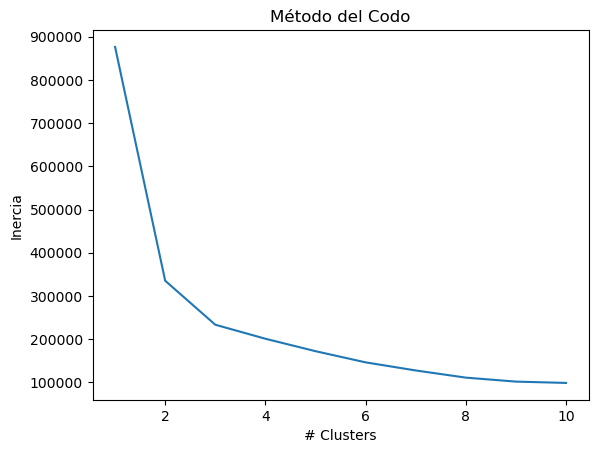

Número óptimo de clusters: 2


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

X = df_median_imputed[['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)','DiaSemana', 'Anio', 'Mes', 'Dia']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(X, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


c:\Users\Ikasle\miniconda3\envs\5073\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Ikasle\miniconda3\envs\5073\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


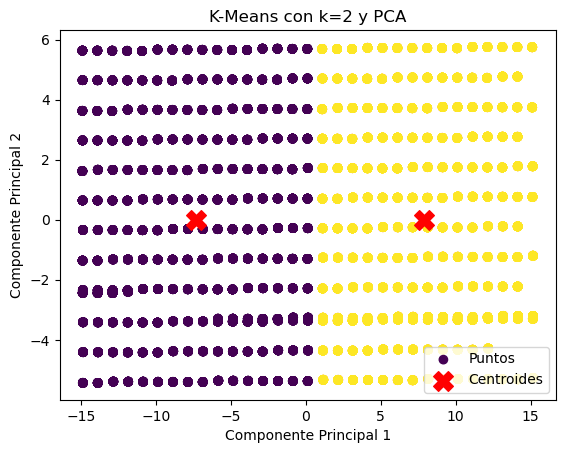

In [109]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


# Realizamos el KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans.fit(X)

# Obtener los resultados
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Aplicar PCA para reducir las dimensiones a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Graficar los resultados con los centroides
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', label='Puntos')
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title(f'K-Means con k={optimal_clusters} y PCA')
plt.legend()
plt.show()


In [ ]:
#  SACAR Pairplot 
import seaborn as sns
import matplotlib.pyplot as plt

# X = df[['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH', 'DiaSemana', 'PeriodoDia', 'indeceContaminacion' ]] 
# y = df[['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']]

X = df[['DiaSemana', 'PeriodoDia', 'indeceContaminacion','Dia', 'Mes', 'Anio' ]] 
y = df[['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']]
# Concatenar las variables de gases con las variables transformadas para visualizar todo en el pairplot
X_with_gases = pd.concat([X, y], axis=1)

# Crear el pairplot para comparar las variables de gases con las características
sns.pairplot(X_with_gases)
plt.show()

In [ ]:
# Seleccionar solo las columnas numéricas
numeric_data = df.select_dtypes(include=['float64', 'int64', 'datetime64'])

# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)

# Añadir título y ajustes
plt.title("Mapa de Correlación del Dataset", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# CONTAMINATES POR DIA DEL MES Y AÑO MIRANDO EL DIA DE LA SEMANA  

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


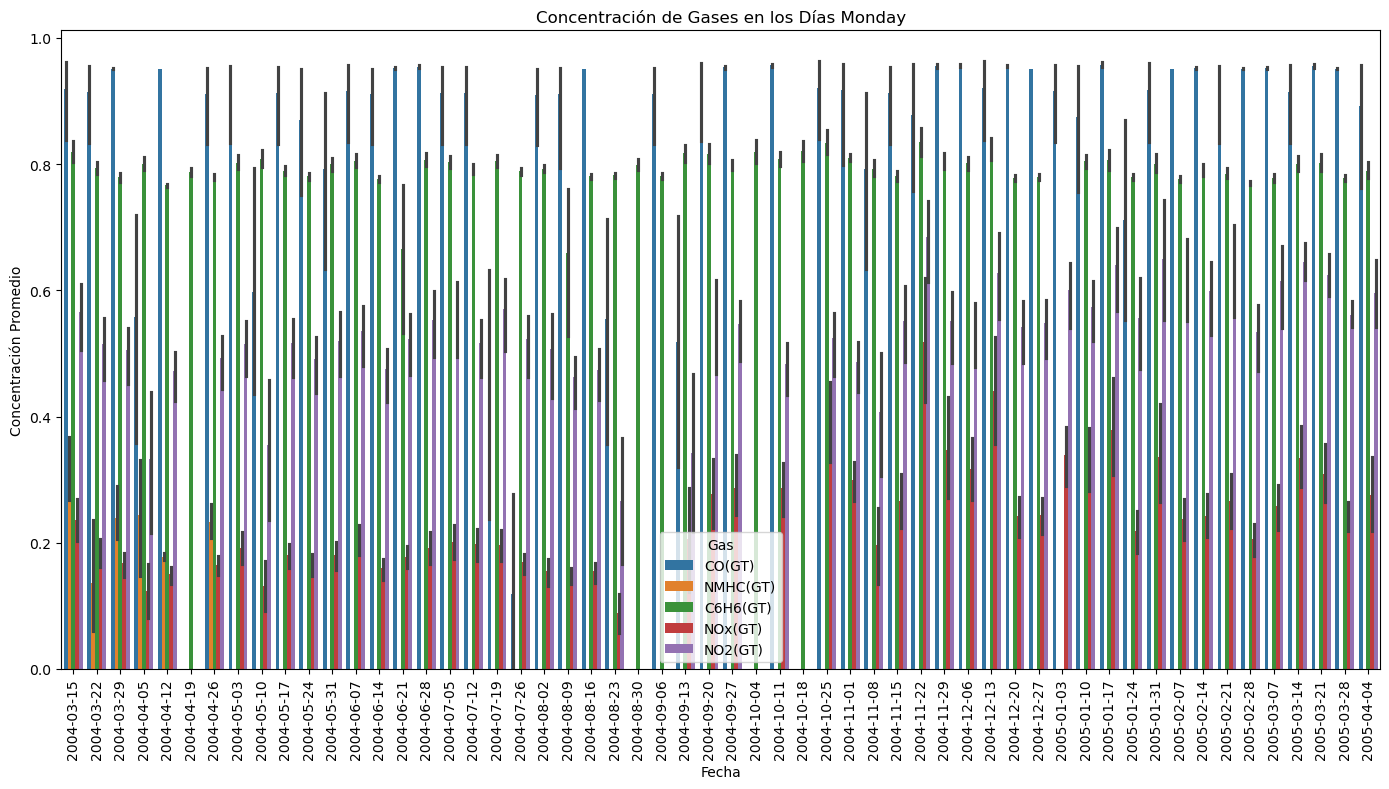

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


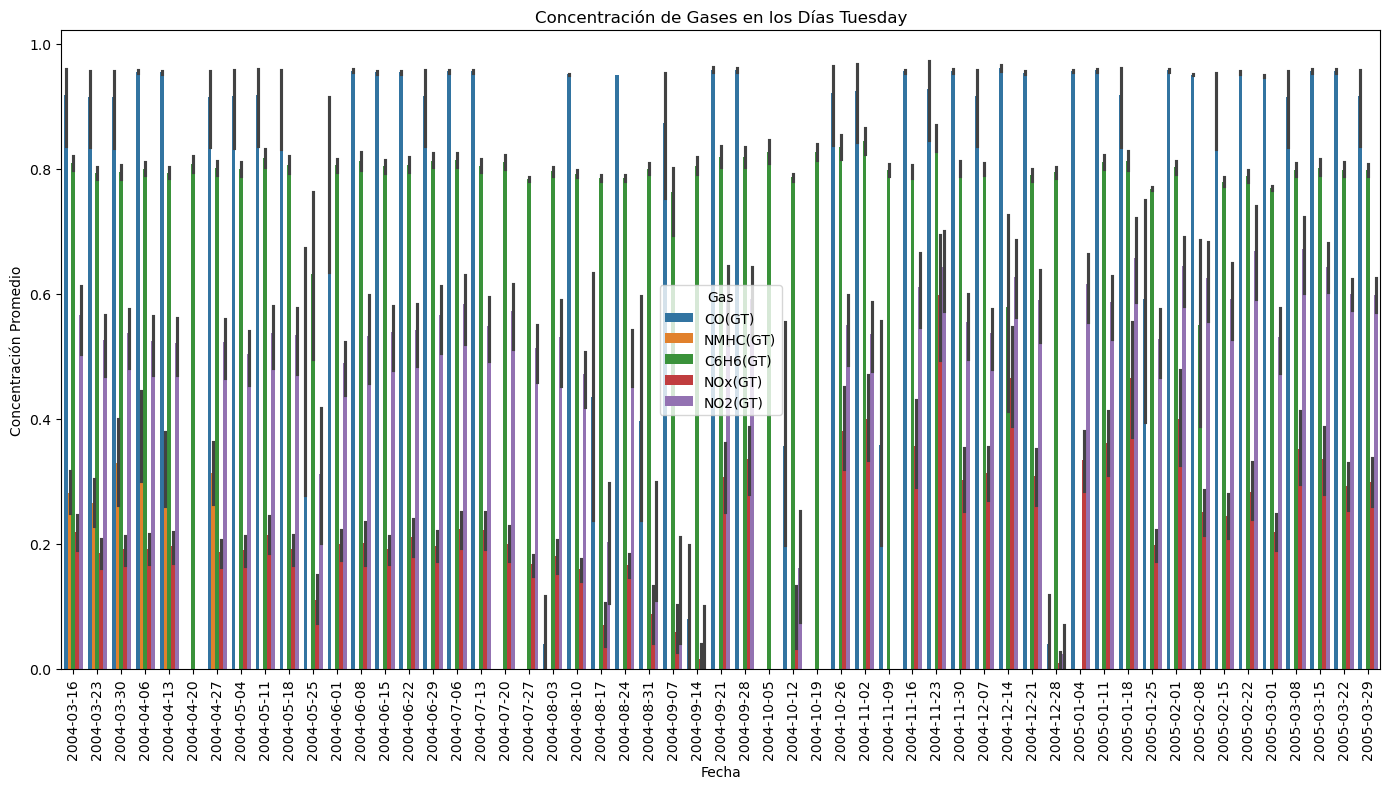

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


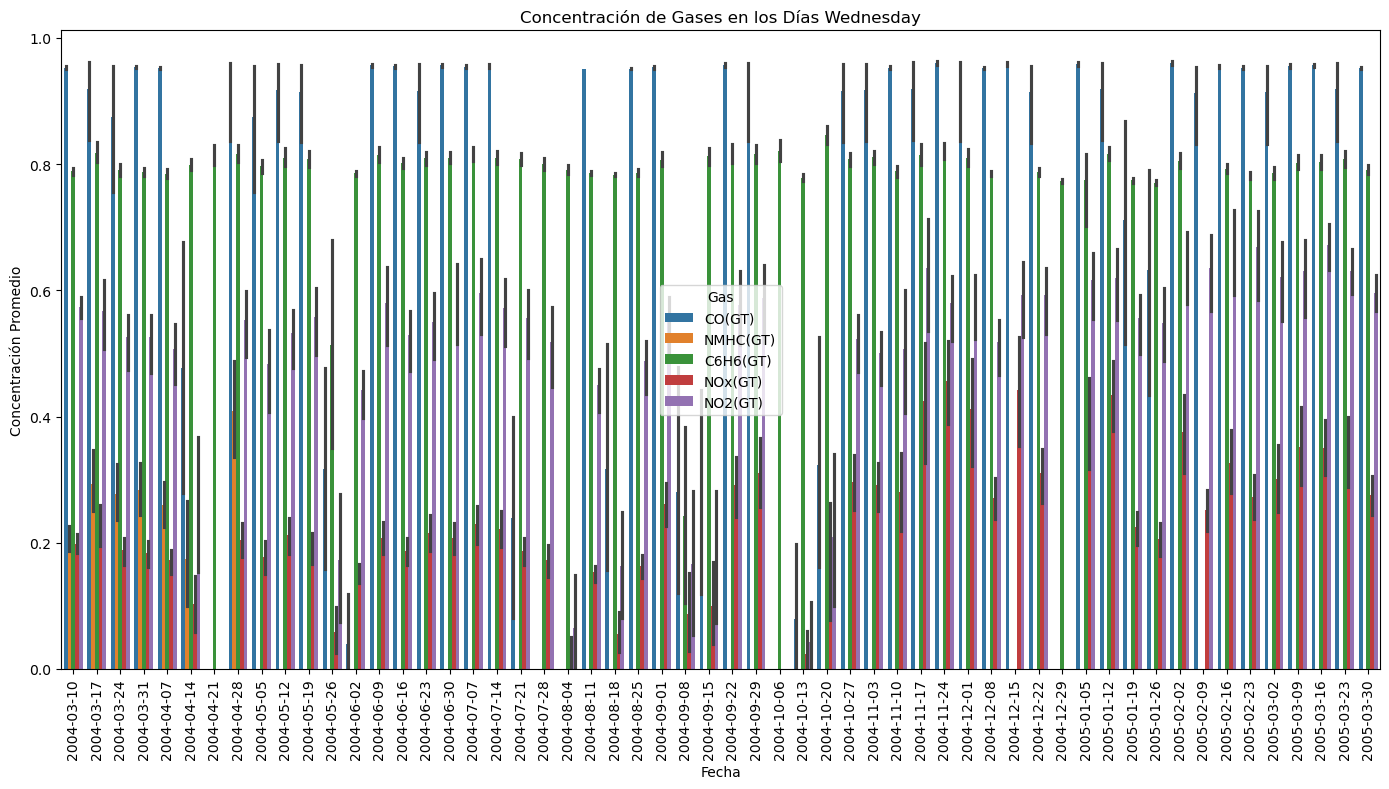

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


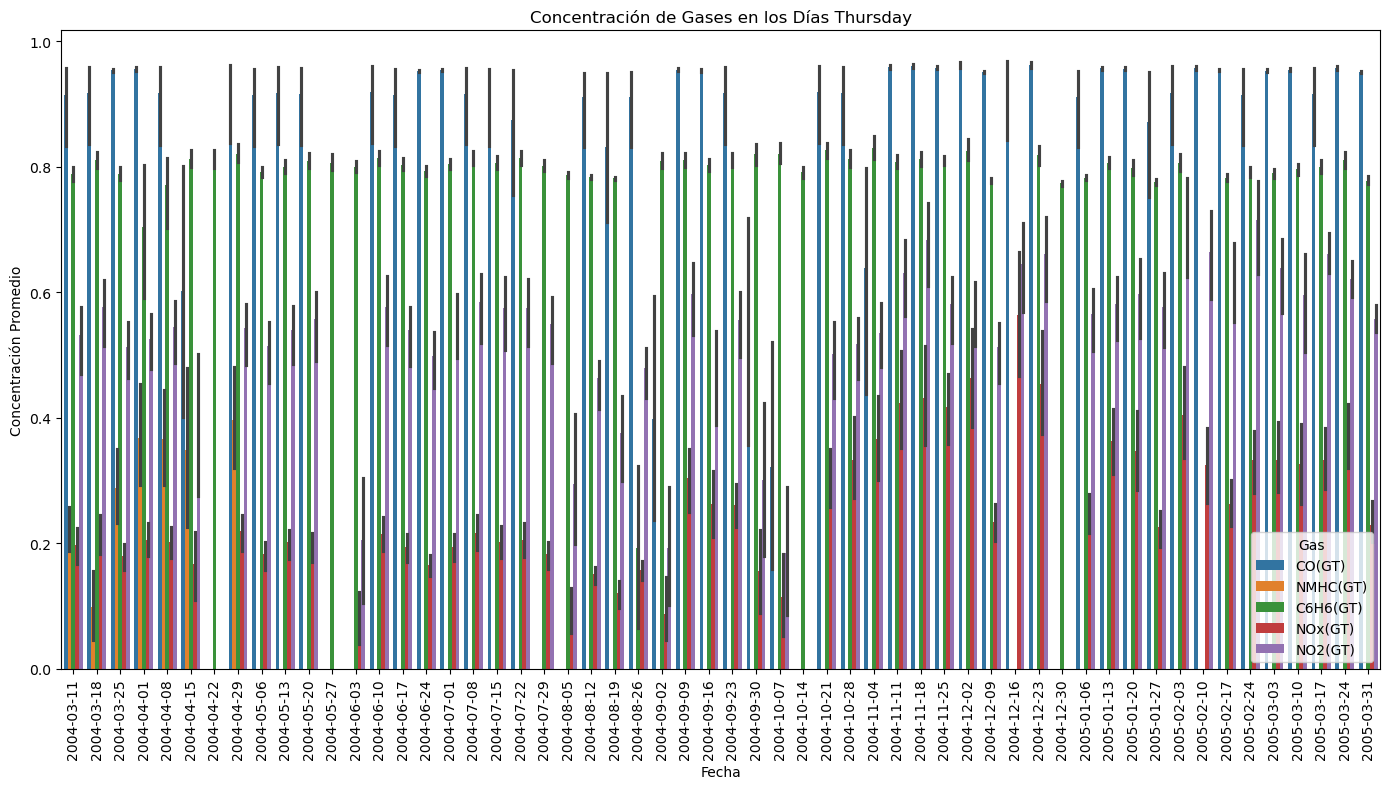

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


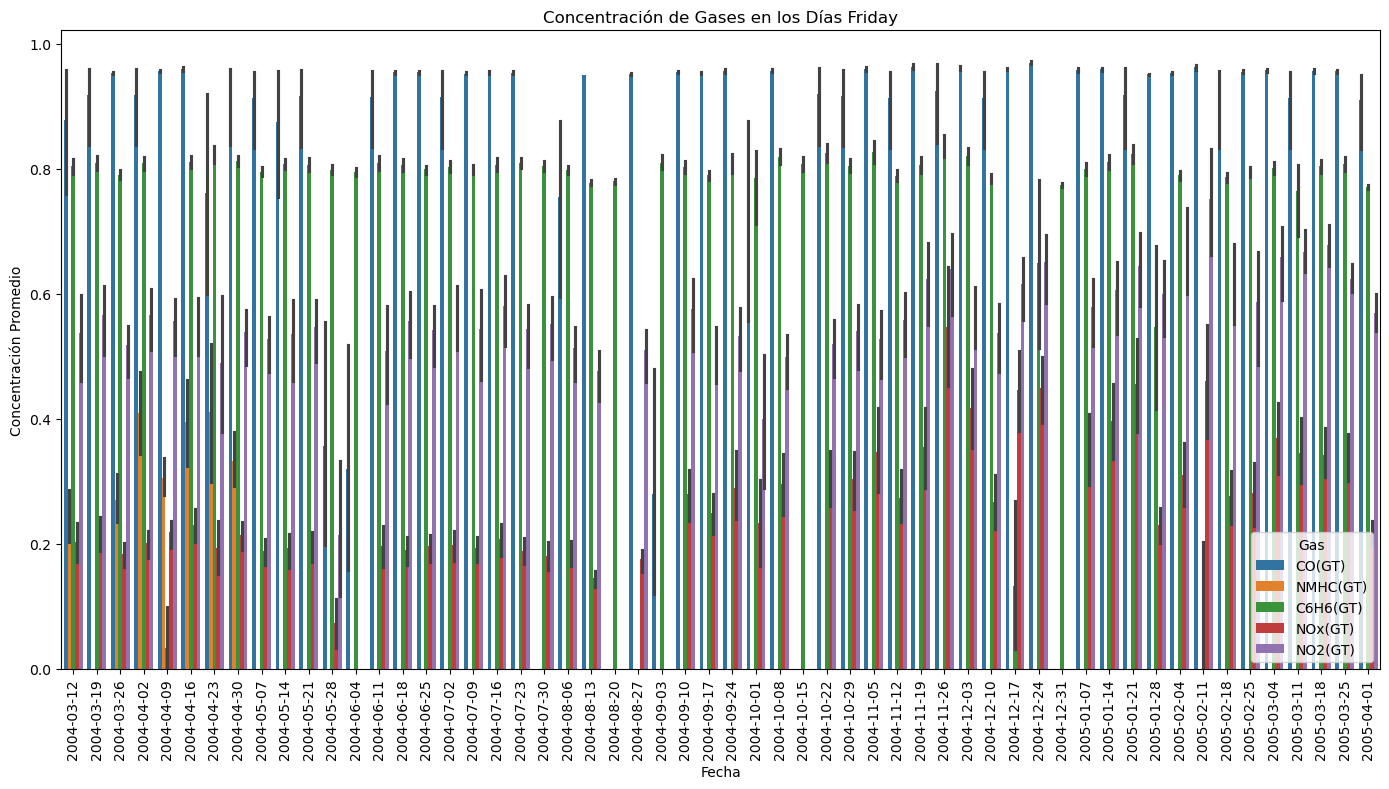

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


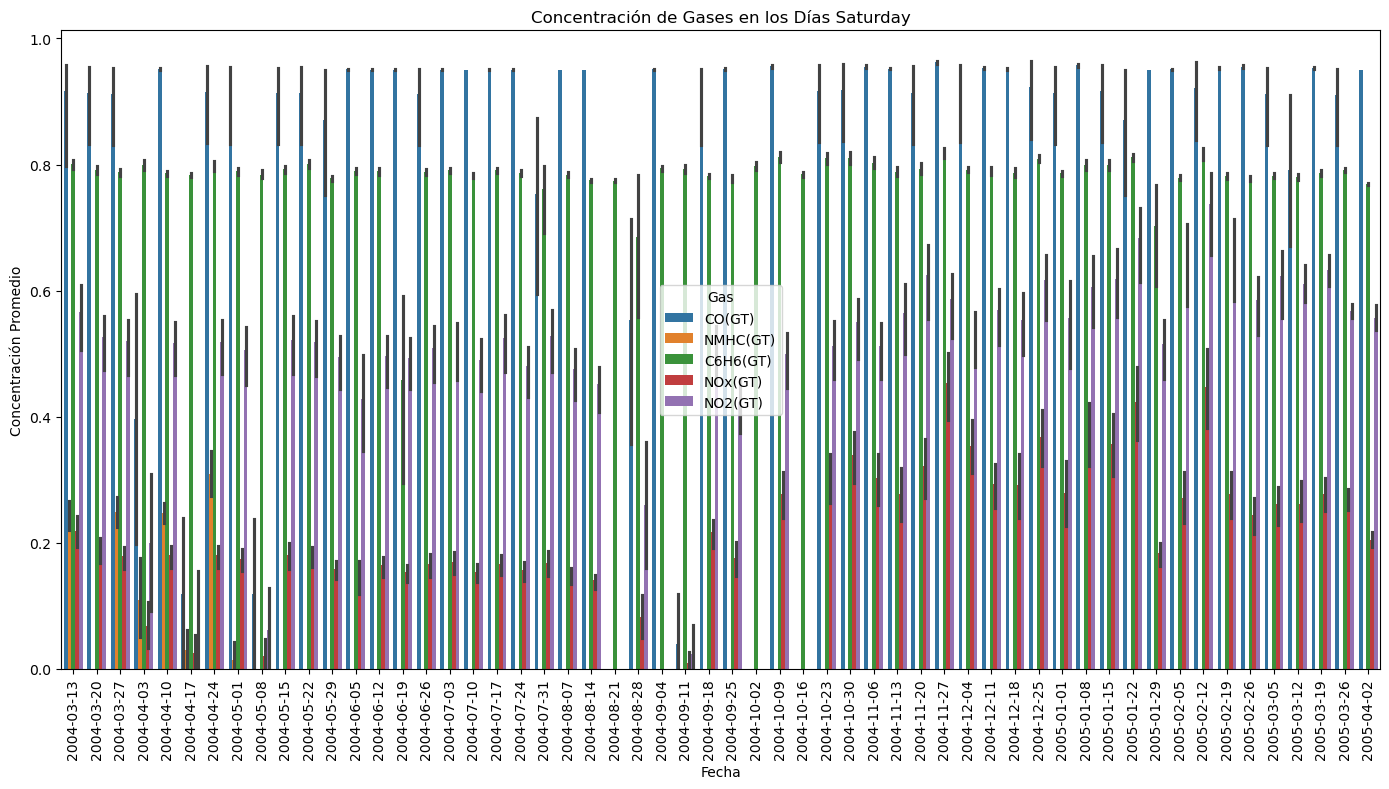

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_12548\1938287202.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')


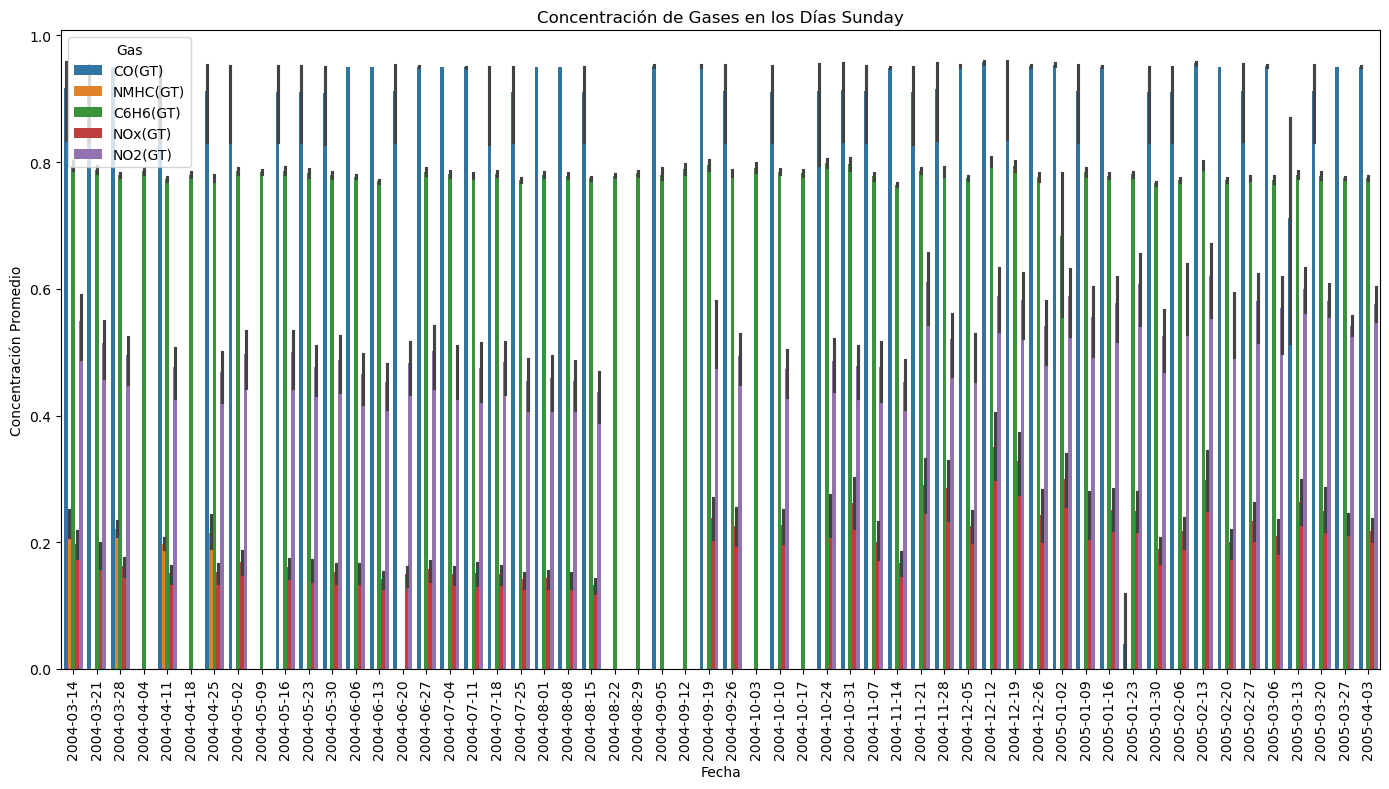

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gases a analizar
gases = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Suponiendo que el DataFrame 'df' ya contiene una columna 'Date' y una columna 'DiaSemana'
df['DiaSemana'] = df['Date'].dt.day_name()

# Mapeo de días de la semana a números
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

# Generar gráficos para cada día de la semana
for dia_semana in dias_semana_map.keys():
    # Filtrar los datos para el día de la semana actual
    df_dia = df[df['DiaSemana'] == dia_semana]
    
    # Crear una nueva columna que combine la fecha para que sea más clara en el eje X
    df_dia['Fecha'] = df_dia['Date'].dt.strftime('%Y-%m-%d')
    
    # Establecer el gráfico
    plt.figure(figsize=(14, 8))

    # Graficar todos los gases para el día de la semana actual
    sns.barplot(
        data=df_dia.melt(id_vars=['Fecha'], value_vars=gases, var_name='Gas', value_name='Concentración'),
        x='Fecha', y='Concentración', hue='Gas', palette='tab10'
    )
    
    # Ajustar el gráfico
    plt.title(f'Concentración de Gases en los Días {dia_semana}')
    plt.xlabel('Fecha')
    plt.ylabel('Concentración Promedio')
    plt.xticks(rotation=90)  # Rotar las etiquetas del eje X para mejor visibilidad
    plt.legend(title='Gas')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
